We will need a GPU for speed-up.

You can change your runtime to GPU via "Runtime -> Change runtime type".

Then, select "GPU" as your "Hardware accelerator" and save.

In [1]:
# check availability of GPU
!nvidia-smi

# 0 . Preliminary

## 0.1. Install packages

We are going to use **PyTorch** (`torch`) and **PyTorch Geometric** (`torch-geometric`) in this tutorial.

PyTorch has already been installed by Google Colab. We need to install PyTorch Geometric along with its required packages with `pip`.

In [2]:
import torch
import os

os.environ['TORCH_VERSION'] = torch.__version__  # get the version of `torch`
print(os.environ['TORCH_VERSION'])

In [3]:
%%bash

# install the corresponding version of `torch-geometric` with `pip`

echo "torch version: ${TORCH_VERSION}"

pip install class_resolver
pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH_VERSION}.html
pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH_VERSION}.html
pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-${TORCH_VERSION}.html
pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${TORCH_VERSION}.html
pip install torch-geometric

## 0.2. Import packages

In [4]:
import time

import torch
import torch.nn.functional as F

from matplotlib import pyplot as plt
from torch import nn
from torch_geometric import transforms
from torch_geometric.datasets import ZINC, QM7b, QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GINConv, MLP
from torch_geometric.nn import VGAE, InnerProductDecoder
from torch_geometric.nn import Set2Set
from torch_geometric.nn import global_mean_pool
from torch_geometric.utils import negative_sampling, remove_self_loops

# Use GPU (cuda) if available. Use CPU otherwise.
# You can change your runtime to GPU via "Runtime -> Change runtime type".
# Then, select "GPU" as your "Hardware accelerator" and save.
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using %s' % DEVICE)

# 1 . Graph Convolutional Networks

We first perform an experiment with GCN (Kipf *et al.*, 2017) for a regression task.

## 1.1. Load dataset

We first define a custom transform.

In [5]:
class TransformComplete(object):
    """build graph and remove loops"""

    def __call__(self, data):
        device = data.edge_index.device

        row = torch.arange(data.num_nodes, dtype=torch.long, device=device)
        col = torch.arange(data.num_nodes, dtype=torch.long, device=device)

        row = row.view(-1, 1).repeat(1, data.num_nodes).view(-1)
        col = col.repeat(data.num_nodes)
        edge_index = torch.stack([row, col], dim=0)

        edge_attr = None
        if data.edge_attr is not None:
            idx = data.edge_index[0] * data.num_nodes + data.edge_index[1]
            size = list(data.edge_attr.size())
            size[0] = data.num_nodes * data.num_nodes
            edge_attr = data.edge_attr.new_zeros(size)
            edge_attr[idx] = data.edge_attr

        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        data.edge_attr = edge_attr
        data.edge_index = edge_index

        return data

We use the `QM9` dataset (Wu *et al.*, 2017), consisting of about 130,000 molecules and 19 regression targets.

The 19 regression targets in the `QM9` dataset are:

| Index | Property | Description | Unit |
|:-----:|:---------|:------------|:-----|
| 0     | $\mu$                      | Dipole moment                                                         | $\textrm{D}$                          |
| 1     | $\alpha$                   | Isotropic polarizability                                              | ${a_0}^3$                             |
| 2     | $\epsilon_{\textrm{HOMO}}$ | Highest occupied molecular orbital energy                             | $\textrm{eV}$                         |
| 3     | $\epsilon_{\textrm{LUMO}}$ | Lowest unoccupied molecular orbital energy                            | $\textrm{eV}$                         |
| 4     | $\Delta \epsilon$          | Gap between $\epsilon_{\textrm{HOMO}}$ and $\epsilon_{\textrm{LUMO}}$ | $\textrm{eV}$                         |
| 5     | $\langle R^2 \rangle$      | Electronic spatial extent                                             | ${a_0}^2$                             |
| 6     | $\textrm{ZPVE}$            | Zero point vibrational energy                                         | $\textrm{eV}$                         |
| 7     | $U_0$                      | Internal energy at 0K                                                 | $\textrm{eV}$                         |
| 8     | $U$                        | Internal energy at 298.15K                                            | $\textrm{eV}$                         |
| 9     | $H$                        | Enthalpy at 298.15K                                                   | $\textrm{eV}$                         |
| 10    | $G$                        | Free energy at 298.15K                                                | $\textrm{eV}$                         |
| 11    | $c_{\textrm{v}}$           | Heat capavity at 298.15K                                              | $\frac{\textrm{cal}}{\textrm{mol K}}$ |
| 12    | $U_0^{\textrm{ATOM}}$      | Atomization energy at 0K                                              | $\textrm{eV}$                         |
| 13    | $U^{\textrm{ATOM}}$        | Atomization energy at 298.15K                                         | $\textrm{eV}$                         |
| 14    | $H^{\textrm{ATOM}}$        | Atomization enthalpy at 298.15K                                       | $\textrm{eV}$                         |
| 15    | $G^{\textrm{ATOM}}$        | Atomization free energy at 298.15K                                    | $\textrm{eV}$                         |
| 16    | $A$                        | Rotational constant                                                   | $\textrm{GHz}$                        |
| 17    | $B$                        | Rotational constant                                                   | $\textrm{GHz}$                        |
| 18    | $C$                        | Rotational constant                                                   | $\textrm{GHz}$                        |


In [6]:
# compose transforms
transform_qm9 = transforms.Compose([
    TransformComplete(),
    transforms.Distance(norm=False),
])

# load the QM9 dataset
data_qm9 = QM9(root = 'data/QM9', transform=transform_qm9)
num_samples = len(data_qm9)

# normalize targets to mean = 0 and std = 1.
mean = data_qm9.data.y.mean(dim=0, keepdim=True)
std = data_qm9.data.y.std(dim=0, keepdim=True)
data_qm9.data.y = (data_qm9.data.y - mean) / std

# split datasets.
data_qm9_train = data_qm9[:int(num_samples * 0.8)]
data_qm9_valid = data_qm9[int(num_samples * 0.8):num_samples]

print('Number of samples: %d' % num_samples)
print('%d samples for train; %d samples for valid' 
      % (len(data_qm9_train), len(data_qm9_valid)))

# create data loaders
loader_qm9_train = DataLoader(data_qm9_train, batch_size=128, shuffle=True)
loader_qm9_valid = DataLoader(data_qm9_valid, batch_size=128, shuffle=False)

Number of samples: 130831
104664 samples for train; 26167 samples for valid


In [7]:
print(data_qm9.data)

Data(x=[2359210, 11], edge_index=[2, 4883516], edge_attr=[4883516, 4], y=[130831, 19], pos=[2359210, 3], idx=[130831], name=[130831], z=[2359210])


## 1.2. Define the GCN

In [8]:
class GCNNetwork(torch.nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, num_outs: int):
        super().__init__()
        
        # stem layer
        self.stem  = nn.Linear(in_channels, hidden_channels)

        # add GCN layers
        self.conv1 = GCNConv(hidden_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
        # the Set2Set aggregation
        self.set2set = Set2Set(hidden_channels, processing_steps=3)

        # add linear layers for regression
        self.linear_1 = nn.Linear(hidden_channels * 2, hidden_channels)
        self.linear_2 = nn.Linear(hidden_channels, num_outs)

    def forward(self, x, edge_index, edge_weight, batch):
        # stem layer
        x = self.stem(x)
        x = F.relu(x)
        
        # GCN layers - 1
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x=x, edge_index=edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        # GCN layers - 2
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x=x, edge_index=edge_index, edge_weight=edge_weight)
        x = F.relu(x)
        
        # set to set aggregation
        x = self.set2set(x, batch)
        
        # regression head
        x = self.linear_1(x)
        x = F.relu(x)
        x = self.linear_2(x)
        return x.squeeze()

## 1.3. Build a GCN and an optimizer

In [9]:
# initialize the GCN model
model_gcn = GCNNetwork(
    in_channels=data_qm9.num_features,
    hidden_channels=64,
    num_outs=19,
).to(DEVICE)

print('model:', model_gcn)

# create an Adam optimizer
optimizer_gcn = torch.optim.Adam(
    model_gcn.parameters(),
    lr=0.001
)

print('optimizer:', optimizer_gcn)

# create a cosine annealing LR scheduler
scheduler_gcn = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer_gcn,
    T_max=100,
)

model: GCNNetwork(
  (stem): Linear(in_features=11, out_features=64, bias=True)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (set2set): Set2Set(64, 128)
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=19, bias=True)
)
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


## 1.4. Train and evaluate the GCN

### 1.4.1. Define the training code

In [10]:
def train_gcn(model, optimizer, loader):
    model.train()  # set the model to the training mode
    loss_all = 0

    for data in loader:
        data = data.to(DEVICE)  # move data to device, cuda or CPU

        optimizer.zero_grad()  # clean previous gradients
        
        out = model(
            x=data.x,
            edge_index=data.edge_index,
            edge_weight=data.edge_weight,
            batch=data.batch,
        )  # calculate output

        loss = F.mse_loss(out, data.y)  # calculate loss

        loss.backward()  # perform back-propagation to calculate gradients

        optimizer.step()  # perform gradient descent to update model

        loss_all += loss.item() * data.num_graphs  # calculate overall loss
    return loss_all / len(loader.dataset)


@torch.no_grad()  # validation does not need gradients
def valid_gcn(model, loader):
    model.eval()  # set the model to the evaluation mode
    loss_all = 0

    for data in loader:
        data = data.to(DEVICE)  # move data to device, cuda or CPU
        
        out = model(
            x=data.x,
            edge_index=data.edge_index,
            edge_weight=data.edge_weight,
            batch=data.batch,
        )  # calculate output

        loss = F.mse_loss(out, data.y)  # calculate loss

        loss_all += loss.item() * data.num_graphs  # calculate overall loss
    return loss_all / len(loader.dataset)

### 1.4.2. Load a checkpoint for evaluation

To save time, we provide a pre-trained checkpoint for evaluation. To train your own model, please refer to `1.4.3`.

In [11]:
# load the checkpoint from file
model_gcn.load_state_dict(
    torch.load('model_gcn-weights.pt')
)

<All keys matched successfully>

In [13]:
loss_valid_gcn_ckpt = valid_gcn(
    model=model_gcn,
    loader=loader_qm9_valid,
)
print('valid_loss = %.2f' % (loss_valid_gcn_ckpt,))

valid_loss = 0.25


### 1.4.3. Train your own model

In [14]:
loss_gcn_train = []
loss_gcn_valid = []
train_time = []

time_stamp_start = time.time()

for epoch in range(100):
    
    _curr_lr = scheduler_gcn.optimizer.param_groups[0]['lr']

    _l_train = train_gcn(
        model=model_gcn,
        optimizer=optimizer_gcn,
        loader=loader_qm9_train,
    )
    loss_gcn_train.append(_l_train)

    _l_valid = valid_gcn(
        model=model_gcn,
        loader=loader_qm9_valid,
    )
    loss_gcn_valid.append(_l_valid)
    
    scheduler_gcn.step()
    
    train_time.append(
        (time.time() - time_stamp_start) / (epoch + 1)
    )    
    print('ep %03d (lr=%.2e): train_loss=%.2f, valid_loss=%.2f, %.2f sec per ep'
          % (epoch + 1, _curr_lr, loss_gcn_train[-1], loss_gcn_valid[-1], train_time[-1]))

print('trained in %.2f minutes' % ((time.time() - time_stamp_start) / 60,))

ep 001 (lr=1.00e-03): train_loss=0.69, valid_loss=0.35, 52.98 sec per ep
ep 002 (lr=1.00e-03): train_loss=0.62, valid_loss=0.34, 52.98 sec per ep
ep 003 (lr=9.99e-04): train_loss=0.61, valid_loss=0.34, 53.09 sec per ep
ep 004 (lr=9.98e-04): train_loss=0.60, valid_loss=0.28, 53.08 sec per ep
ep 005 (lr=9.96e-04): train_loss=0.59, valid_loss=0.28, 53.09 sec per ep
ep 006 (lr=9.94e-04): train_loss=0.58, valid_loss=0.31, 52.98 sec per ep
ep 007 (lr=9.91e-04): train_loss=0.57, valid_loss=0.31, 52.89 sec per ep
ep 008 (lr=9.88e-04): train_loss=0.57, valid_loss=0.29, 52.83 sec per ep
ep 009 (lr=9.84e-04): train_loss=0.55, valid_loss=0.30, 52.82 sec per ep
ep 010 (lr=9.80e-04): train_loss=0.55, valid_loss=0.30, 52.78 sec per ep
ep 011 (lr=9.76e-04): train_loss=0.51, valid_loss=0.28, 52.74 sec per ep
ep 012 (lr=9.70e-04): train_loss=0.50, valid_loss=0.28, 52.71 sec per ep
ep 013 (lr=9.65e-04): train_loss=0.55, valid_loss=0.26, 52.69 sec per ep
ep 014 (lr=9.59e-04): train_loss=0.53, valid_loss=0

In [15]:
def draw_plot_gcn(loss_train_array, loss_valid_array):
    fig, ax1 = plt.subplots(figsize=(4, 3), dpi=144)
    ax2 = ax1.twinx()
    handles = []
    
    _p, = ax1.plot(loss_train_array, label='train', color='blue')
    handles.append(_p)
    _p, = ax2.plot(loss_valid_array, label='valid', color='red')
    handles.append(_p)
    
    ax1.legend(handles=handles)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('train')
    ax2.set_ylabel('valid')

    plt.show()

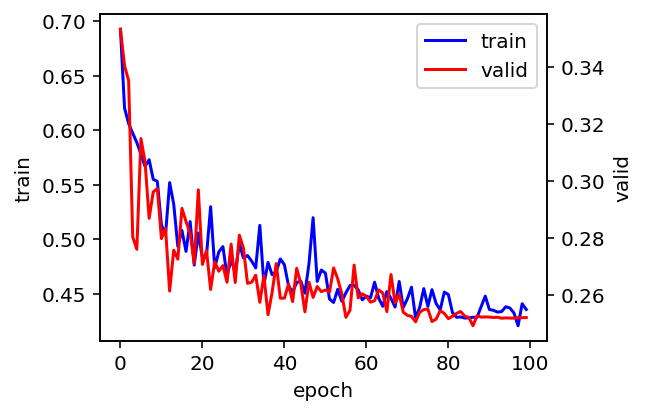

In [16]:
draw_plot_gcn(
    loss_train_array=loss_gcn_train,
    loss_valid_array=loss_gcn_valid,
)

## 1.5. Save the model to a file

In [17]:
model_gcn_weights = model_gcn.state_dict()
print(model_gcn_weights.keys())

odict_keys(['stem.weight', 'stem.bias', 'conv1.bias', 'conv1.lin.weight', 'conv2.bias', 'conv2.lin.weight', 'set2set.lstm.weight_ih_l0', 'set2set.lstm.weight_hh_l0', 'set2set.lstm.bias_ih_l0', 'set2set.lstm.bias_hh_l0', 'linear_1.weight', 'linear_1.bias', 'linear_2.weight', 'linear_2.bias'])


In [18]:
torch.save(model_gcn_weights, 'model_gcn-weights.pt')

# 2 . Variational Graph Auto-Encoders

Now, we use a VGAE (Kipf *et al.*, 2016) to generate molecule graphs.

## 2.1. Load Dataset

We still use the QM9 dataset but with the `NormalizeFeatures` transform.

In [19]:
# compose transforms
transform_qm9_vgae = transforms.Compose([
    transforms.NormalizeFeatures(),
])

# load the QM9 dataset
data_qm9_vgae = QM9(root = 'data/QM9', transform=transform_qm9_vgae)
num_samples_vgae = len(data_qm9_vgae)

# normalize targets to mean = 0 and std = 1
mean = data_qm9_vgae.data.y.mean(dim=0, keepdim=True)
std = data_qm9_vgae.data.y.std(dim=0, keepdim=True)
data_qm9_vgae.data.y = (data_qm9_vgae.data.y - mean) / std

# split datasets
data_qm9_train_vgae = data_qm9_vgae[:int(num_samples_vgae * 0.8)]
data_qm9_valid_vgae = data_qm9_vgae[int(num_samples_vgae * 0.8):num_samples_vgae]

print('Number of samples: %d' % num_samples_vgae)
print('%d samples for train; %d samples for valid' 
      % (len(data_qm9_train_vgae), len(data_qm9_valid_vgae)))

# create data loaders
loader_qm9_train_vgae = DataLoader(data_qm9_train_vgae, batch_size=128, shuffle=True)
loader_qm9_valid_vgae = DataLoader(data_qm9_valid_vgae, batch_size=128, shuffle=False)

Number of samples: 130831
104664 samples for train; 26167 samples for valid


In [20]:
print(data_qm9_vgae.data)

Data(x=[2359210, 11], edge_index=[2, 4883516], edge_attr=[4883516, 4], y=[130831, 19], pos=[2359210, 3], idx=[130831], name=[130831], z=[2359210])


## 2.2. Define the variational auto-encoder

In [21]:
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv_mu = GCNConv(hidden_channels, out_channels)
        self.conv_logstd = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

## 2.3. Build a VGAE and an optimizer

In [22]:
# initialize the VGAE model
model_vgae = VGAE(
    encoder=VariationalGCNEncoder(
        in_channels=data_qm9_vgae.num_features,
        hidden_channels=64,
        out_channels=2,
    ),
    decoder=InnerProductDecoder()
).to(DEVICE)

print(model_vgae)

# create an Adam optimizer
optimizer_vgae = torch.optim.Adam(
    model_vgae.parameters(),
    lr=0.005
)

print('optimizer:', optimizer_vgae)

# create a cosine annealing LR scheduler
scheduler_vgae = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer_vgae,
    T_max=100,
)

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GCNConv(11, 64)
    (conv_mu): GCNConv(64, 2)
    (conv_logstd): GCNConv(64, 2)
  )
  (decoder): InnerProductDecoder()
)
optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.005
    weight_decay: 0
)


## 2.4. Train and evaluate the GCN

### 2.4.1. Define the training code

In [23]:
def vgae_train(model, optimizer, loader):
    model.train()  # set the model to the training mode
    loss_all = 0

    for data in loader:
        data = data.to(DEVICE)  # move data to device, cuda or CPU
        optimizer.zero_grad()  # clean previous gradients

        z = model.encode(data.x, data.edge_index)  # calculate output

        # loss = reconstruction_loss + kl_divergency_loss
        loss = model.recon_loss(z, data.edge_index) + (1 / data.num_nodes) * model.kl_loss()
        # loss = model.recon_loss(z, data.edge_index)

        loss.backward()  # perform back-propagation to calculate gradients
        optimizer.step()  # perform gradient descent to update model

        loss_all += loss.item() * data.num_graphs  # calculate overall loss
    return loss_all / len(loader.dataset)


@torch.no_grad()  # validation does not need gradients
def vgae_valid(model, loader):
    model.eval()  # set the model to the evaluation mode
    auc_all = 0
    ap_all = 0

    for data in loader:
        data = data.to(DEVICE)  # move data to device, cuda or CPU

        z = model.encode(data.x, data.edge_index)  # calculate output

        # generate negative samples for evaluation
        neg_edge_index = negative_sampling(
            edge_index=data.edge_index,
            num_nodes=data.num_nodes,
            num_neg_samples=data.edge_index.size(1),
        )
        
        auc, ap = model.test(z, pos_edge_index=data.edge_index, neg_edge_index=neg_edge_index)

        auc_all += auc.item() * data.num_graphs  # calculate overall loss
        ap_all += ap.item() * data.num_graphs  # calculate overall loss
    return auc_all / len(loader.dataset), ap_all / len(loader.dataset)

### 2.4.2. Load a checkpoint for evaluation

To save time, we provide a pre-trained checkpoint for evaluation. To train your own model, please refer to `2.4.3`.

In [24]:
# load the checkpoint from file
model_vgae.load_state_dict(
    torch.load('model_vgae-weights.pt')
)

<All keys matched successfully>

In [26]:
auc_valid_vgae_ckpt, ap_valid_vgae_ckpt = vgae_valid(
    model=model_vgae,
    loader=loader_qm9_valid_vgae,
)
print('valid_auc=%.2f, valid_ap=%.2f' % (auc_valid_vgae_ckpt, ap_valid_vgae_ckpt))

valid_auc=0.81, valid_ap=0.78


### 2.4.3. Train your own model

In [27]:
loss_vgae_train = []
auc_vgae_valid = []
ap_vgae_valid = []
train_time_vgae = []

time_stamp_start_vgae = time.time()

for epoch in range(50):
    
    _curr_lr = scheduler_vgae.optimizer.param_groups[0]['lr']

    _l_train = vgae_train(
        model=model_vgae,
        optimizer=optimizer_vgae,
        loader=loader_qm9_train_vgae,
    )
    loss_vgae_train.append(_l_train)

    _auc_valid, _ap_valid = vgae_valid(
        model=model_vgae,
        loader=loader_qm9_valid_vgae,
    )

    auc_vgae_valid.append(_auc_valid)
    ap_vgae_valid.append(_ap_valid)
    
    scheduler_vgae.step()
    
    train_time_vgae.append(
        (time.time() - time_stamp_start_vgae) / (epoch + 1)
    )    
    print('ep %03d (lr=%.2e): train_loss=%.2f, valid_auc=%.2f, valid_ap=%.2f, %.2f sec per ep'
          % (epoch + 1, _curr_lr, loss_vgae_train[-1],
             auc_vgae_valid[-1], ap_vgae_valid[-1], train_time_vgae[-1]))

print('trained in %.2f minutes' % ((time.time() - time_stamp_start_vgae) / 60,))

ep 001 (lr=5.00e-03): train_loss=1.23, valid_auc=0.75, valid_ap=0.72, 14.83 sec per ep
ep 002 (lr=5.00e-03): train_loss=1.14, valid_auc=0.78, valid_ap=0.74, 14.96 sec per ep
ep 003 (lr=5.00e-03): train_loss=1.13, valid_auc=0.79, valid_ap=0.75, 14.90 sec per ep
ep 004 (lr=4.99e-03): train_loss=1.11, valid_auc=0.80, valid_ap=0.77, 14.86 sec per ep
ep 005 (lr=4.98e-03): train_loss=1.10, valid_auc=0.80, valid_ap=0.76, 14.84 sec per ep
ep 006 (lr=4.97e-03): train_loss=1.10, valid_auc=0.80, valid_ap=0.77, 14.83 sec per ep
ep 007 (lr=4.96e-03): train_loss=1.10, valid_auc=0.80, valid_ap=0.77, 14.82 sec per ep
ep 008 (lr=4.94e-03): train_loss=1.09, valid_auc=0.81, valid_ap=0.78, 14.84 sec per ep
ep 009 (lr=4.92e-03): train_loss=1.09, valid_auc=0.80, valid_ap=0.77, 14.83 sec per ep
ep 010 (lr=4.90e-03): train_loss=1.09, valid_auc=0.81, valid_ap=0.77, 14.81 sec per ep
ep 011 (lr=4.88e-03): train_loss=1.09, valid_auc=0.80, valid_ap=0.77, 14.81 sec per ep
ep 012 (lr=4.85e-03): train_loss=1.09, vali

In [28]:
def draw_plot_vgae(valid_auc, valid_ap):
    fig, ax1 = plt.subplots(figsize=(4, 3), dpi=144)
    ax2 = ax1.twinx()
    handles = []
    
    _p, = ax1.plot(valid_auc, label='valid_auc', color='blue')
    handles.append(_p)
    _p, = ax2.plot(valid_ap, label='valid_ap', color='red')
    handles.append(_p)
    
    ax1.legend(handles=handles)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('valid_auc')
    ax2.set_ylabel('valid_ap')

    plt.show()

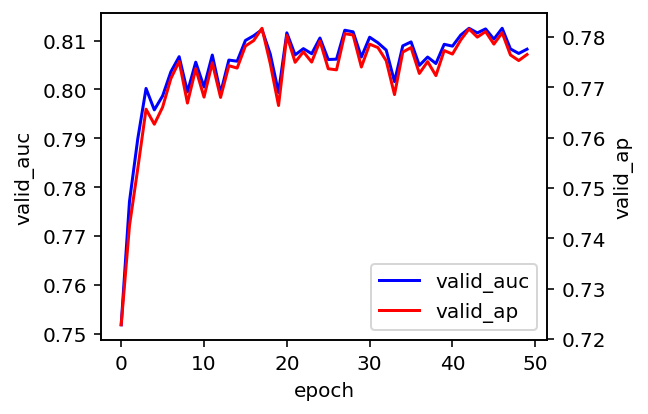

In [29]:
draw_plot_vgae(
    valid_auc=auc_vgae_valid,
    valid_ap=ap_vgae_valid,
)

## 2.5. Save the model to a file

In [30]:
model_vgae_weights = model_vgae.state_dict()
print(model_vgae_weights.keys())

odict_keys(['encoder.conv1.bias', 'encoder.conv1.lin.weight', 'encoder.conv_mu.bias', 'encoder.conv_mu.lin.weight', 'encoder.conv_logstd.bias', 'encoder.conv_logstd.lin.weight'])


In [31]:
torch.save(model_vgae_weights, 'model_vgae-weights.pt')

# Reference

- Kipf *et al.*, *Variational Graph Auto-Encoders*. In *Bayesian Deep Learning Workshop at Neural Information Processing Systems (NeurIPS)*, 2016. [[Link](https://arxiv.org/abs/1611.07308)]
- Kipf *et al.*, *Semi-supervised Classification with Graph Convolutional Networks*. In *Proceedings of the International Conference on Learning Representations (ICLR)*, 2017. [[Link](https://arxiv.org/abs/1609.02907)]
- Wu *et al.*, *MoleculeNet: A Benchmark for Molecular Machine Learning*. In *Chemical Science*, 2017. [[Link](https://arxiv.org/abs/1703.00564)]